In [62]:
%matplotlib inline
import numpy as np
from rnn.arch import RNN
from vae.arch import VAE
import matplotlib.pyplot as plt
from gym.utils import seeding
from IPython import display
import time

batch_num = 0

In [144]:
rnn = RNN()
rnn.set_weights('./rnn/weights.h5')

vae = VAE()
vae.set_weights('./vae/weights.h5')

In [129]:
# obs_data = np.load('./data/obs_data_car_racing_' + str(batch_num) + '.npy') 
# action_data = np.load('./data/action_data_car_racing_' + str(batch_num) + '.npy')
# reward_data = np.load('./data/reward_data_car_racing_' + str(batch_num) + '.npy') 
# done_data = np.load('./data/done_data_car_racing_' + str(batch_num) + '.npy')
rnn_input = np.load('./data/rnn_input_' + str(batch_num) + '.npy') 
rnn_output = np.load('./data/rnn_output_' + str(batch_num) + '.npy')

In [4]:
rnn_input[0].shape

(299, 35)

In [5]:
rnn_output[0].shape

(299, 34)

In [6]:
GAUSSIAN_MIXTURES = 5
Z_DIM = 32
z_dim = 32

def get_mixture_coef(z_pred):

    log_pi, mu, log_sigma = np.split(z_pred, 3, 1)
    log_pi = log_pi - np.log(np.sum(np.exp(log_pi), axis = 1, keepdims = True))

    return log_pi, mu, log_sigma


In [7]:
def get_pi_idx(x, pdf):
  # samples from a categorial distribution
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    random_value = np.random.randint(N)
    #print('error with sampling ensemble, returning random', random_value)
    return random_value

In [149]:
def sample_z(mu, log_sigma):
    z =  mu + (np.exp(log_sigma)) * np_random.randn(*log_sigma.shape) *0.5
    return z

In [9]:
np_random, seed = seeding.np_random()

In [72]:
def sample_next_mdn_output(obs):
    
    d = GAUSSIAN_MIXTURES * Z_DIM
    
    y_pred = rnn.model.predict(np.array([[obs]]))
    
    z_pred = y_pred[:,:,:(3*d)]
#     print(z_pred)
    z_pred = np.reshape(z_pred, [-1, GAUSSIAN_MIXTURES * 3])
    
#     print(obs)
#     print(z_pred)

    log_pi, mu, log_sigma = get_mixture_coef(z_pred)
    

    chosen_log_pi = np.zeros(z_dim)
    chosen_mu = np.zeros(z_dim)
    chosen_log_sigma = np.zeros(z_dim)
    
    # adjust temperatures
    logmix2 = np.copy(log_pi)
#     logmix2 -= logmix2.max()
    logmix2 = np.exp(logmix2)
    logmix2 /= logmix2.sum(axis=1).reshape(z_dim, 1)

    for j in range(z_dim):
        idx = get_pi_idx(np_random.rand(), logmix2[j])
        idx = 0
        chosen_log_pi[j] = idx
        chosen_mu[j] = mu[j,idx]
        chosen_log_sigma[j] = log_sigma[j,idx]
        
    

    next_z = sample_z(chosen_mu, chosen_log_sigma)

#     reward = np.exp(reward) / (1 + np.exp(reward))
#     done = np.exp(done) / (1 + np.exp(done))

#     if reward > 0.5:
#         next_reward = 3.2
#     else:
#         next_reward = -0.1

#     if done > 0.5:
#         next_done = True
#     else:
#         next_done = False
        
#     return next_z, next_reward, next_done, chosen_mu, chosen_sigma, chosen_pi

    return next_z, chosen_mu, chosen_log_sigma, chosen_log_pi

In [154]:
run_idx = 10

obs = rnn_input[run_idx]
actual = rnn_output[run_idx] 
print(obs.shape)
print(actual.shape)


idx = 0



(249, 35)
(249, 34)


<function matplotlib.pyplot.show>

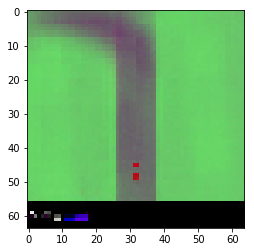

In [133]:
z_decoded = vae.decoder.predict(np.array(obs[:, :32]))
plt.imshow(z_decoded[idx])
plt.show

<function matplotlib.pyplot.show>

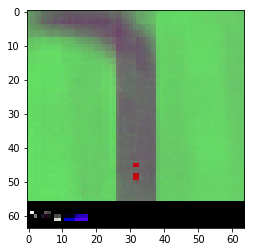

In [134]:
actual_z_decoded = vae.decoder.predict(np.array(actual[:, :32]))
plt.imshow(actual_z_decoded[idx])
plt.show

6.453902694365956
[-0.27814225 -1.52413321  1.11108328  0.80956202 -0.72133213  1.88521632
  0.23349418 -0.19858525  0.06605233  0.34583226 -0.86397146 -0.83720175
  2.67246848 -0.01502789 -0.52827521  0.68965582 -0.22573067  0.06554373
  0.1589217  -0.8155041  -1.19219281  1.12876713  0.04191386  1.69755716
  0.12881917  1.04648166 -1.10143184  0.77902426  1.34099989 -1.47950425
 -1.08959188  1.51397563  0.          1.          0.        ]
[-0.67524631  0.3026933   0.43517472  0.9505433  -0.68642295  2.08856819
  1.35607974  0.09701891  1.03505271 -1.68107485 -0.41471317 -1.60410655
  0.22911005 -0.00425803 -0.4487341   1.13304555 -0.03622756 -0.34755787
 -2.0117251   0.79972235 -0.82660321  0.01957942  0.2898704  -0.99859554
 -0.10386831 -0.00986256  0.1550559  -0.81898912 -2.16505385 -0.15917065
 -1.27138998  1.62129361  0.          0.        ]
[[[0.0171803]]]
[[[-0.09727208]]]
[5.164093  5.212387  4.7313275 3.950294  5.9364038]


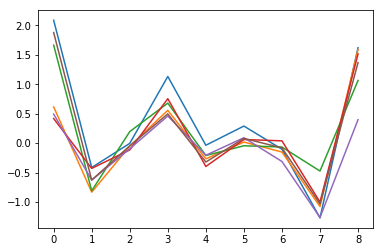

In [145]:
d = GAUSSIAN_MIXTURES * Z_DIM

print(sum(np.abs(obs[idx,[5,10,13,15,16,22, 24, 30, 31]])))
print(obs[idx])
print(actual[idx])
# plt.plot(obs[idx,[5,10,13,15,16,22, 24, 30, 31]])
plt.plot(actual[idx,[5,10,13,15,16,22, 24, 30, 31]])
y_pred = rnn.model.predict(np.array([[obs[idx,:]]]))

z_pred = y_pred[:,:,:(3*d)]
rew_pred = y_pred[:,:,(3*d):(3*d+1)]
done_pred = y_pred[:,:,(3*d+1):]

# print(rew_pred)
# print(done_pred)

z_pred = np.reshape(z_pred, [-1, GAUSSIAN_MIXTURES * 3])

# plt.figure(figsize=(20,20))

# plt.subplot(411)
# plt.plot(z_pred.transpose())

log_pi, mu, log_sigma = np.split(z_pred, 3, 1)

# plt.subplot(412)
# plt.plot(log_pi)

# plt.subplot(412)
plt.plot(mu[[5,10,13,15,16,22, 24, 30, 31]])

# plt.subplot(414)
# plt.plot(log_sigma)


log_pi = log_pi - np.log(np.sum(np.exp(log_pi), axis = 1, keepdims = True))

print(sum(np.abs(mu[[5,10,13,15,16,22, 24, 30, 31]])))


In [136]:
next_z = obs[idx,:]

[-0.27814225 -1.52413321  1.11108328  0.80956202 -0.72133213  1.88521632
  0.23349418 -0.19858525  0.06605233  0.34583226 -0.86397146 -0.83720175
  2.67246848 -0.01502789 -0.52827521  0.68965582 -0.22573067  0.06554373
  0.1589217  -0.8155041  -1.19219281  1.12876713  0.04191386  1.69755716
  0.12881917  1.04648166 -1.10143184  0.77902426  1.34099989 -1.47950425
 -1.08959188  1.51397563  0.          1.          0.        ]
[-0.0561881  -0.3349669  -0.29258071  0.15874156 -0.21514533  0.76725344
  0.32466661 -0.38922666 -0.06032437 -0.31264896 -0.42874908 -0.37567244
 -0.07215261 -0.31049216  1.40810458  0.28154388 -0.0990478  -0.74036796
  0.09828201  0.33003873  0.2341808   0.13506164  0.22106841 -0.35070717
 -0.14374386  0.47227744 -0.90231938 -0.34366076  0.00251635 -0.79262552
 -0.77927927  0.91007919  0.          1.          0.        ]


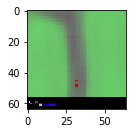

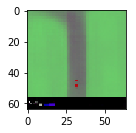

In [137]:
print(next_z)

# next_z, next_reward, next_done, chosen_mu, chosen_sigma, chosen_pi = sample_next_mdn_output(obs)
next_z, chosen_mu, chosen_log_sigma, chosen_pi = sample_next_mdn_output(next_z)
# print(chosen_pi)
# print(chosen_mu)
# print(chosen_log_sigma)
# print(next_z)

next_z_decoded = vae.decoder.predict(np.array([next_z]))[0]
next_mu_decoded = vae.decoder.predict(np.array([chosen_mu]))[0]

next_z = np.concatenate([next_z, [0,1,0]])

print(next_z)

plt.subplot(211)
plt.imshow( next_z_decoded)
plt.show()
plt.subplot(221)
plt.imshow( next_mu_decoded)
plt.show()
# plt.imshow(next_z_decoded)
# plt.show()

(34, 249)


/Users/davidfoster/.virtualenvs/worldmodels/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


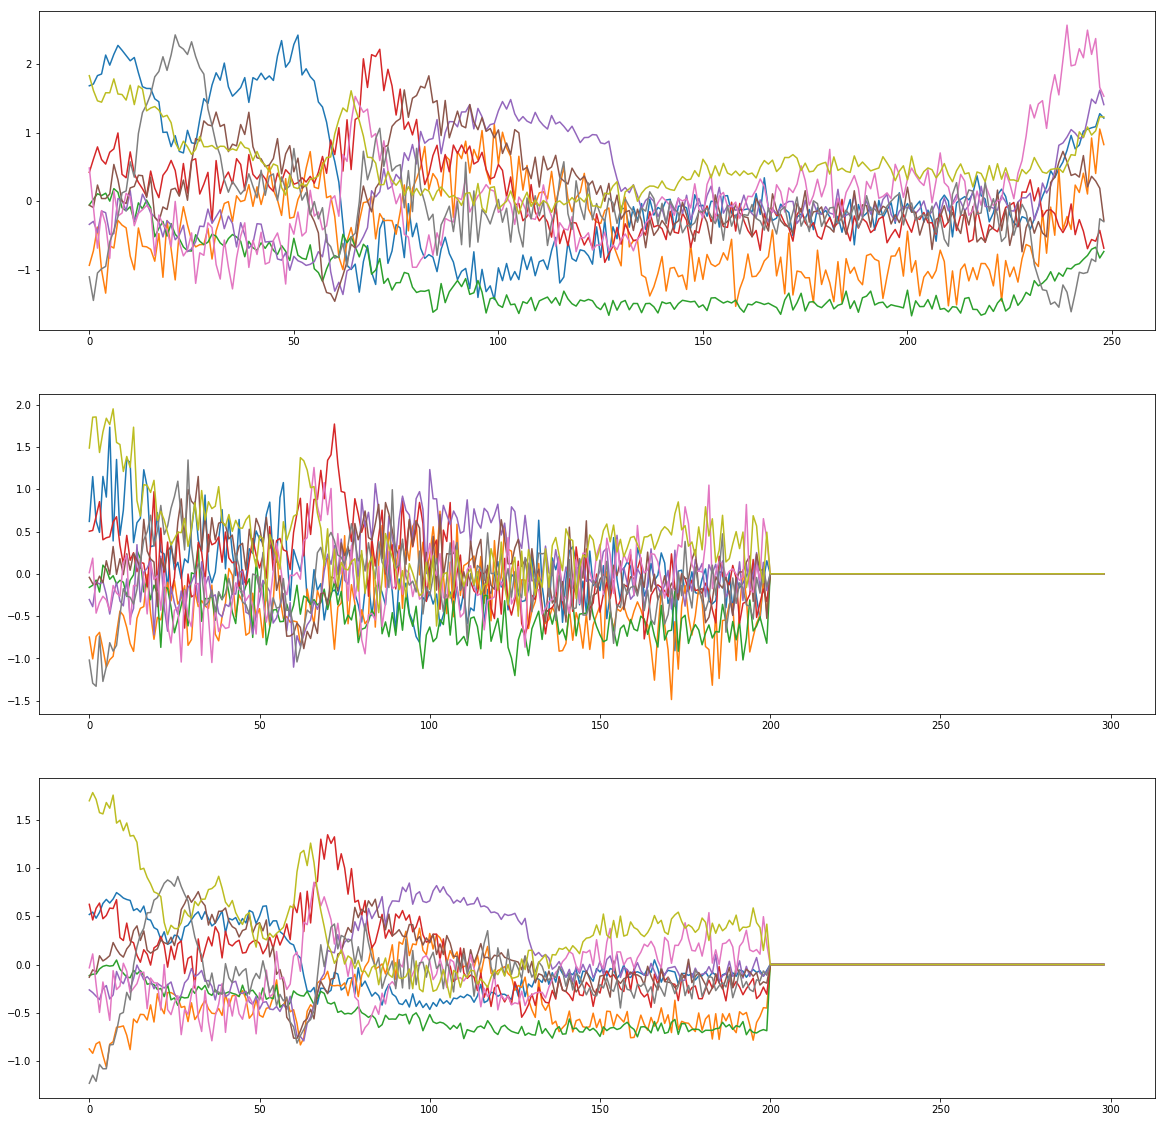

In [155]:
b = np.swapaxes(rnn_output[run_idx],0,1)
print(b.shape)

next_zs = np.zeros(shape = (32,299))
next_mus = np.zeros(shape = (32,299))
# next_z = np.copy(obs)
# print(next_z.shape)
for i in range(200):
    next_z, chosen_mu, chosen_log_sigma, chosen_pi = sample_next_mdn_output(obs[i,:])
    next_mus[:,i] = chosen_mu
    next_zs[:,i] = next_z
    next_z_decoded = vae.decoder.predict(np.array([next_z]))[0]
    
    # plt.imshow(next_z_decoded)
    # plt.show()
    # next_z = np.concatenate([next_z, np.array([0,1,0])])

plt.figure(figsize=(20,20))
for i in [5,10,13,15,16,22, 24, 30, 31]:
    plt.subplot(311)
    plt.plot( b[i,:])
    plt.subplot(312)
    plt.plot( next_zs[i,:])
    plt.subplot(313)
    plt.plot( next_mus[i,:])
    
# print(next_zs)
    

KeyboardInterrupt: 

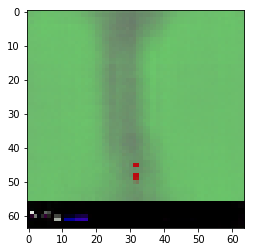

In [158]:

next_z = obs[0]
# next_z_decoded = vae.decoder.predict(np.array([next_z]))[0]
# plt.imshow( next_z_decoded)
# plt.show()

for i in range(200):
#     print(np.array([[next_z]]).shape)
    next_z, chosen_mu, chosen_log_sigma, chosen_pi = sample_next_mdn_output(next_z)

    next_z_decoded = vae.decoder.predict(np.array([next_z]))[0]
#     next_mu_decoded = vae.decoder.predict(np.array([chosen_mu]))[0]

    next_z = np.concatenate([next_z, [1,0,0]])

#     plt.subplot(211)
    plt.gca().cla() 
    plt.imshow( next_z_decoded)
#     plt.show()
    display.clear_output(wait=True)
    display.display(plt.gcf()) 
    time.sleep(0.02) 

#     plt.subplot(221)
#     plt.imshow( next_mu_decoded)
#     plt.show()
    # plt.imshow(next_z_decoded)
    # plt.show()

(34, 249)


/Users/davidfoster/.virtualenvs/worldmodels/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


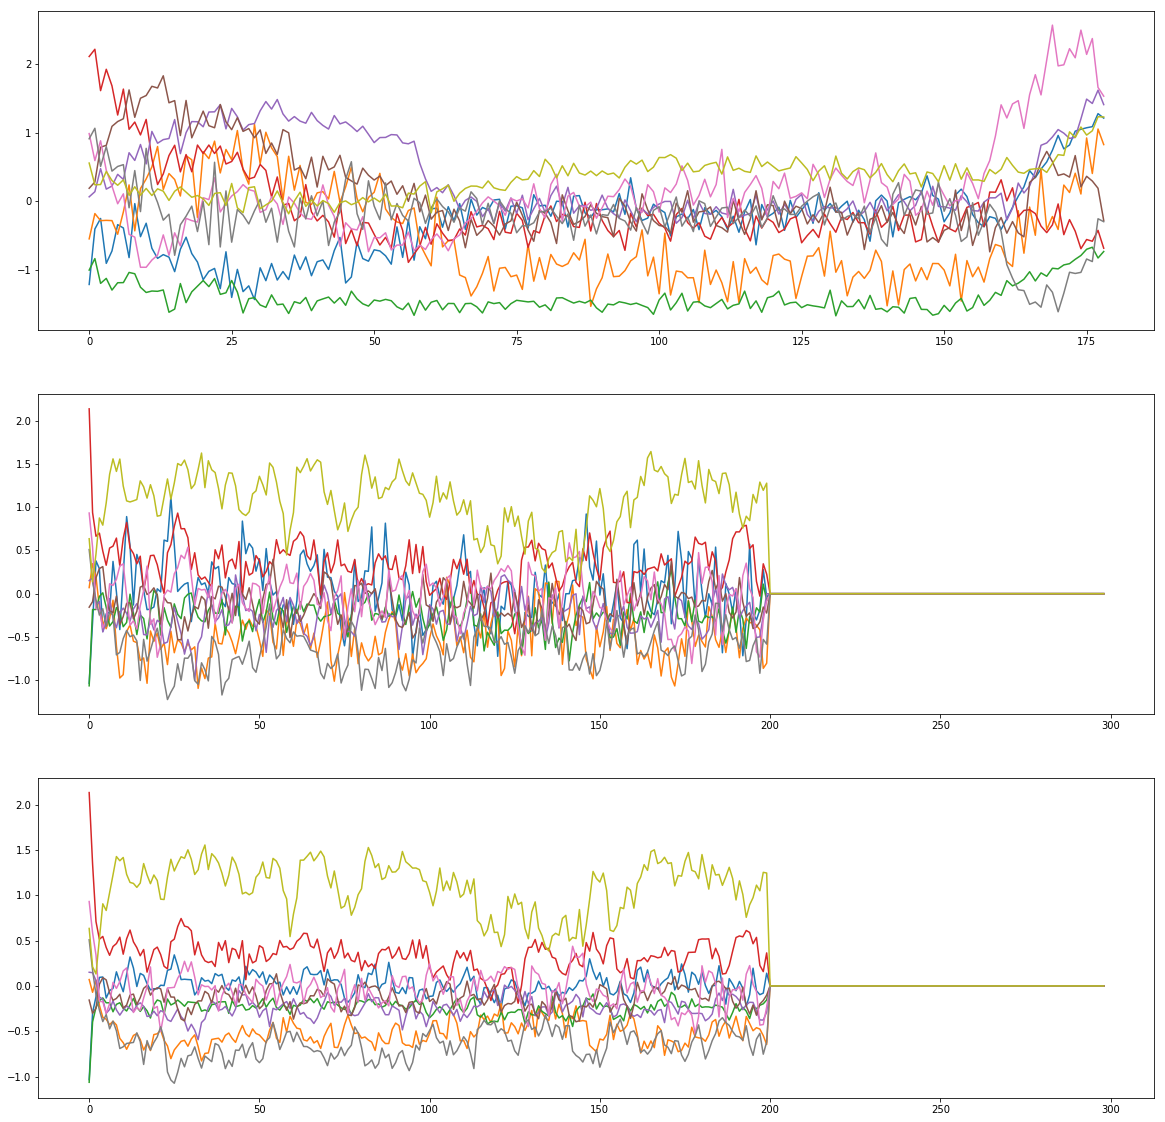

In [159]:
b = np.swapaxes(rnn_output[run_idx],0,1)
print(b.shape)

next_zs = np.zeros(shape = (32,299))
next_mus = np.zeros(shape = (32,299))
# next_z = np.copy(obs)
# print(next_z.shape)
next_z = obs[70]

next_mus[:,0] = next_z[:32]
next_zs[:,0] = next_z[:32]

for i in range(1,200):
    next_z, chosen_mu, chosen_log_sigma, chosen_pi = sample_next_mdn_output(next_z)
    next_mus[:,i] = chosen_mu
    next_zs[:,i] = next_z
    next_z_decoded = vae.decoder.predict(np.array([next_z]))[0]
    
    # plt.imshow(next_z_decoded)
    # plt.show()
    # next_z = np.concatenate([next_z, np.array([0,1,0])])
    
    next_z = np.concatenate([next_z, [0,1,0]])

plt.figure(figsize=(20,20))
for i in [5,10,13,15,16,22, 24, 30, 31]:
    plt.subplot(311)
    plt.plot( b[i,70:])
    plt.subplot(312)
    plt.plot( next_zs[i,:])
    plt.subplot(313)
    plt.plot( next_mus[i,:])
    
# print(next_zs)
    